#Introduction
In this notebook, we will implement a machine-learning framework accelerates functional high-entropy alloy discovery

In [ ]:
import cv2
import os
import time
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root = 'content/'

sns.set(color_codes=True)

#Required packages

In [ ]:
!pip install bayesian-optimization
!pip install lightgbm

#Wasserstein Autoencoder
Wasserstein autoencoder is used for learning the latent space representation.

the block below shows two utility functions that converting numpy array to tensors.

In [ ]:
class FeatureDataset(Dataset): #from numpy to tensor (pytroch-readable)
    '''
    Args: x is a 2D numpy array [x_size, x_features]
    '''
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.x[idx]), torch.FloatTensor(self.y[idx])

class AttributeDataset(Dataset): # this is for classifier 
    '''
    Args: x is a 2D numpy array [x_size, x_features]
    '''
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.Tensor(self.x[idx]), torch.Tensor(self.y[idx])

**Model architecture**

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class WAE(nn.Module):
    def __init__(self, input_size):
        super(WAE, self).__init__()
        self.input_size = input_size

        # encoder
        self.encoder = nn.Sequential(
                        nn.Linear(self.input_size, 80),
                        nn.LayerNorm(80),
                        nn.ReLU(),
                        nn.Linear(80, 64),
                        nn.LayerNorm(64),
                        nn.ReLU(),
                        nn.Linear(64, 48),
                        nn.LayerNorm(48),
                        nn.ReLU(),
                        nn.Linear(48, 2),
                        )

        # decoder
        self.decoder = nn.Sequential(
                        nn.Linear(2, 48),
                        nn.LayerNorm(48),
                        nn.ReLU(),
                        nn.Linear(48, 64),
                        nn.LayerNorm(64),
                        nn.ReLU(),
                        nn.Linear(64, 80),
                        nn.LayerNorm(80),
                        nn.ReLU(),
                        nn.Linear(80, self.input_size),
                        nn.Softmax(dim=1) #(softmad along dimension 1)
                        )
        self.apply(weights_init)
    
    def forward(self, x):
        z = self._encode(x)
        x_recon = self._decode(z)

        return x_recon, z
    
    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)

**Utility functions for WAE**


*   same_seeds: fixing the randomness
*   get_latents: get the latent spaces from the WAE
*   imq_kernels: inverse multiquadric (IMQ) kernel - computing the maximum mean discrepancy, which is part of the loss function for WAE.



In [ ]:
def same_seeds(seed): #fix np & torch seed to the same.
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def get_latents(model, dataset): #from dataset to altten
    model.to(device).eval() # training model or evaluation mode, eval means setting the model to its evaluation mode (gradient fixed)
    latents = []
    with torch.no_grad(): # fix the gradient, assure that the model parameters are fixed
        dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
        for i, data in enumerate(dataloader):
            x = data[0].to(device)
            recon_x, z = model(x)
            latents.append(z.detach().cpu().numpy())
    return np.concatenate(latents,axis=0)

def imq_kernel(X: torch.Tensor, Y: torch.Tensor, h_dim: int): # common kerntl to choose
    batch_size = X.size(0)

    norms_x = X.pow(2).sum(1, keepdim=True)  # batch_size x 1
    prods_x = torch.mm(X, X.t()).to(device)  # batch_size x batch_size
    dists_x = norms_x + norms_x.t() - 2 * prods_x # mm matrix multiplicaiton

    norms_y = Y.pow(2).sum(1, keepdim=True).to(device)  # batch_size x 1
    prods_y = torch.mm(Y, Y.t()).to(device)  # batch_size x batch_size
    dists_y = norms_y + norms_y.t() - 2 * prods_y

    dot_prd = torch.mm(X, Y.t())
    dists_c = norms_x + norms_y.t() - 2 * dot_prd

    stats = 0
    for scale in [.1, .2, .5, 1., 2., 5., 10.]: # need more study on this
        C = 2 * h_dim * 1.0 * scale
        res1 = C / (C + dists_x)
        res1 += C / (C + dists_y)

        if torch.cuda.is_available():
            res1 = (1 - torch.eye(batch_size).to(device)) * res1
        else:
            res1 = (1 - torch.eye(batch_size)) * res1

        res1 = res1.sum() / (batch_size - 1)
        res2 = C / (C + dists_c)
        res2 = res2.sum() * 2. / (batch_size)
        stats += res1 - res2

    return stats


**Data loading**  

params - here you can play around with all different combinations of paramters to reduce the total loss. You can visualize your training history just to see how good your chosen set of hyperparameters performs

In [ ]:
same_seeds(1) #seed equals to 1

params = {
    'num_epoch' : 200,
    'batch_size' : 20,
    'lr' : 5e-4,
    'weight_decay' : 0.0,
    'sigma' : 8.0,
    'MMD_lambda' : 1e-4,
    'model_name' : 'WAE_v1',
} # for WAE training
all = pd.read_csv('data_base.csv', header=0).iloc[:,1:19].to_numpy()
raw_x = all[:696,:6]
raw_y = all[:696,17].reshape(-1,1)
dataset = FeatureDataset(raw_x[:], raw_y[:]) #numpy to tensor
dataloader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True) # tensor to dataloader
print(raw_x[50:55])

[[0.701 0.2   0.099 0.    0.    0.   ]
 [0.65  0.25  0.1   0.    0.    0.   ]
 [0.62  0.28  0.1   0.    0.    0.   ]
 [0.601 0.3   0.099 0.    0.    0.   ]
 [0.58  0.32  0.1   0.    0.    0.   ]]


In [ ]:
model = WAE(raw_x.shape[1]).to(device) # initialize the model 
optimizer = Adam(model.parameters(), lr = params['lr'], weight_decay = params['weight_decay']) # optimizer
def train_WAE(model, optimizer, dataloader, params):
    model_name = params['model_name']
    num_epoch = params['num_epoch']
    sigma = params['sigma'] # assuming the latent space follows Gaussian
    MMD_lambda = params['MMD_lambda'] #WAE distance (maximum mean discrepancy)

    folder_dir = os.path.join(root, model_name) # a folder to save models
    if not os.path.isdir(folder_dir):
        os.mkdir(folder_dir)
    loss_=[]   
    for epoch in range(num_epoch):
        start_time = time.time()
        total_loss = [] #save for plot, recon loss+MMD
        total_recon = [] # binary cross entropy
        total_MMD = [] #maximum mean discrepancy
        
        for i, data in enumerate(dataloader):
            x = data[0].to(device)
            y = data[1].to(device)
            model.train() # model goes to train mode
            recon_x, z_tilde = model(x) # latent space is Z_tilde
            z = sigma*torch.randn(z_tilde.size()).to(device) # z is sampled from a Gaussian that has the same dimension (but no relation to z_tilde).

            recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean') #lowest reconstruction loss 
            #recon_loss = F.mse_loss(recon_x, x, reduction='mean') 
            #recon_loss = F.l1_loss(recon_x, x, reduction='mean')
            
            MMD_loss = imq_kernel(z_tilde, z, h_dim=2).to(device) #W-distance between z_tilde and z
            MMD_loss = MMD_loss / x.size(0) #averaging, because recon loss is mean.
            loss = recon_loss + MMD_loss * MMD_lambda #MM_lambda: learning-rate alike, hyperparamer

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())# from tensor to values
            total_recon.append(recon_loss.item())
            total_MMD.append(MMD_loss.item())

        avg_loss = sum(total_loss)/len(total_loss)
        avg_recon = sum(total_recon)/len(total_recon)
        avg_MMD = sum(total_MMD)/len(total_MMD)
        loss_.append(avg_loss)

        #scheduler.step(avg_loss)

        print('[{:03}/{:03}] loss: {:.6f} Recon_loss: {:.6f}, MMD_loss:{:.6f}, time: {:.3f} sec'.format(\
                                        epoch+1, num_epoch, \
                                        avg_loss, \
                                        avg_recon, avg_MMD, time.time() - start_time))
        # save the model every 5 epoches
        if (epoch+1) % 5 == 0:
            save_model_dir = str(model_name + "_{}.pth".format(epoch+1))
            torch.save(model.state_dict(), os.path.join(folder_dir, save_model_dir))
    return loss_

loss_=train_WAE(model, optimizer, dataloader, params)
plt.figure()
sns.set_style('ticks')
plt.plot(range(len(loss_)),loss_)

[001/100] loss: 0.365287 Recon_loss: 0.364788, MMD_loss:4.988922, time: 0.201 sec
[002/100] loss: 0.319609 Recon_loss: 0.319189, MMD_loss:4.200815, time: 0.198 sec
[003/100] loss: 0.311577 Recon_loss: 0.311122, MMD_loss:4.544367, time: 0.194 sec
[004/100] loss: 0.308807 Recon_loss: 0.308342, MMD_loss:4.655530, time: 0.197 sec
[005/100] loss: 0.307247 Recon_loss: 0.306776, MMD_loss:4.710283, time: 0.217 sec
[006/100] loss: 0.306054 Recon_loss: 0.305588, MMD_loss:4.664705, time: 0.186 sec
[007/100] loss: 0.305088 Recon_loss: 0.304617, MMD_loss:4.708817, time: 0.220 sec
[008/100] loss: 0.304573 Recon_loss: 0.304105, MMD_loss:4.686302, time: 0.209 sec
[009/100] loss: 0.303707 Recon_loss: 0.303228, MMD_loss:4.788946, time: 0.195 sec
[010/100] loss: 0.302751 Recon_loss: 0.302280, MMD_loss:4.713873, time: 0.227 sec
[011/100] loss: 0.301802 Recon_loss: 0.301345, MMD_loss:4.570692, time: 0.194 sec
[012/100] loss: 0.301485 Recon_loss: 0.301018, MMD_loss:4.667446, time: 0.191 sec
[013/100] loss: 

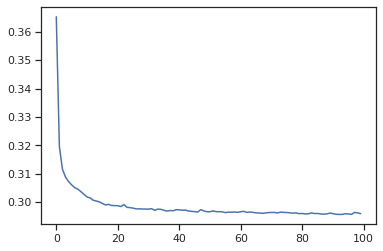

**Double check on the reconstructed compositions**




*   one way to find out whether WAE (or any other VAE) has learned the 
repsentation is to compare the reconstructed and original compositions.if you are not happy with the reconstruction. go back to the previous step and change the params. 



In [ ]:
#double check on the recontructed compositions
#t = time.localtime()
model_dir = os.path.join(root,'{}/{}_{}.pth'.format(params['model_name'], params['model_name'],params['num_epoch']))#load your model
model = WAE(raw_x.shape[1]).to(device)
model.load_state_dict(torch.load(model_dir))
model.eval()
with torch.no_grad():
    test = torch.FloatTensor(raw_x).to(device)
    recon_x, z = model(test)
    recon_x = model.decoder(z)
    recon_x = recon_x.cpu().detach().numpy()

column_name = ['Fe','Ni','Co','Cr','V','Cu']#,'VEC','AR1','AR2','PE','Density','TC','MP','FI','SI','TI','M']
#recon_x = (recon_x * (max-min)) + min
pd.DataFrame(recon_x.round(3), columns=column_name).loc[690:695]

Fe     Ni     Co     Cr      V   Cu
690  0.614  0.330  0.053  0.000  0.003  0.0
691  0.613  0.331  0.052  0.000  0.003  0.0
692  0.612  0.323  0.062  0.001  0.002  0.0
693  0.608  0.326  0.063  0.000  0.003  0.0
694  0.608  0.317  0.072  0.001  0.002  0.0
695  0.605  0.320  0.073  0.001  0.002  0.0

In [ ]:
csv_data = pd.read_csv('data_base.csv', header=0).iloc[:,1:19]
csv_data.iloc[690:696,:6].round(3)

Fe     Ni    Co   Cr    V   Cu
690  0.630  0.330  0.04  0.0  0.0  0.0
691  0.625  0.335  0.04  0.0  0.0  0.0
692  0.635  0.315  0.05  0.0  0.0  0.0
693  0.625  0.325  0.05  0.0  0.0  0.0
694  0.635  0.305  0.06  0.0  0.0  0.0
695  0.625  0.315  0.06  0.0  0.0  0.0

**Visualize the WAE latent space**

Here we assign different colors to alloy with and without Copper,
as we expected them to differ significantly in the latent space.



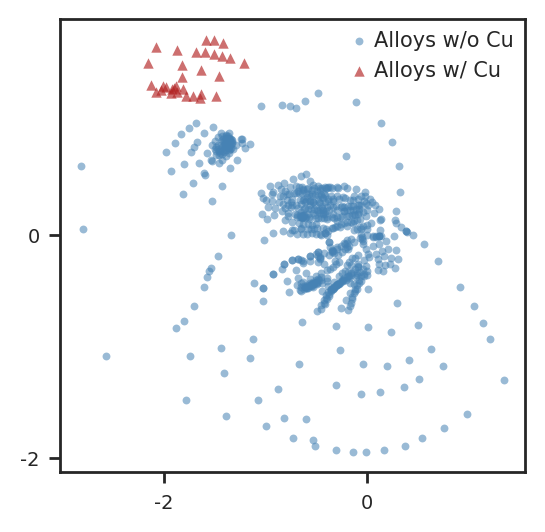

In [ ]:
sns.set_style('ticks')
model = WAE(raw_x.shape[1]).to(device)
model.load_state_dict(torch.load(model_dir))
dataset = FeatureDataset(raw_x[:], raw_y[:])
latents = get_latents(model, dataset)

low_cu = raw_x[:,5] < 0.05
low_cu_latent = latents[low_cu]
low_cu_color = raw_y[:][low_cu]

high_cu = raw_x[:,5] >= 0.05
high_cu_latent = latents[high_cu]
high_cu_color = raw_y[:][high_cu]


# figure settings
fig, axs = plt.subplots(figsize = (3, 3),dpi=200)

#axs.set_aspect(1.)
#axs.set_ylim(-7,7)
#axs.set_xlim(-11,5)

axs.set_yticks(np.arange(-6, 8, step=2))
axs.set_xticks(np.arange(-10, 5, step=2))

axs.set_yticklabels(np.arange(-6, 8, step=2), fontsize=7)
axs.set_xticklabels(np.arange(-10, 5, step=2), fontsize=7)


for axis in ['top','bottom','left','right']:
  axs.spines[axis].set_linewidth(1.)


axs.tick_params(axis='both', which='major', top=False, labeltop=False, direction='out', width=1., length=4)
axs.tick_params(axis='both', which='major', right=False, labelright=False, direction='out', width=1., length=4)

#scatter1 = axs.scatter(low_cu_latent[:,0], low_cu_latent[:,1], c=low_cu_color, alpha=.75, s=10, linewidths=0, cmap='viridis')
#scatter2 = axs.scatter(high_cu_latent[:,0], high_cu_latent[:,1], c=high_cu_color, alpha=.75, s=9, linewidths=0, cmap='Reds')

scatter1 = axs.scatter(low_cu_latent[:,0], low_cu_latent[:,1], c='steelblue', alpha=.55, s=8, linewidths=0, label='Alloys w/o Cu')
scatter2 = axs.scatter(high_cu_latent[:,0], high_cu_latent[:,1], c='firebrick', alpha=.65, s=14, linewidths=0, marker='^', label='Alloys w/ Cu')
#scatter3 = axs.scatter(latents_exp_4[:,0], latents_exp_4[:,1], alpha=1., s=10, linewidths=.75, edgecolors='darkslategray', facecolors='w')#, label='New FeCoNiCr HEAs')
#scatter4 = axs.scatter(latents_exp_5[:,0], latents_exp_5[:,1], alpha=1., s=16, linewidths=.75, edgecolors='darkred', facecolors='w',marker='^')#, label='New FeCoNiCrCu HEAs')

handles,labels = axs.get_legend_handles_labels()
handles = handles[::1]
labels = labels[::1]

legend_properties = {'size':7.5}
axs.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.015,1.017), handletextpad=-0.3, frameon=False, prop=legend_properties)
#axs.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.045,1.017), handletextpad=-0.3, frameon=False, prop=legend_properties)

#rect = patches.Rectangle((-19.4,15.0), 18, 4.5, linewidth=0,edgecolor=None,facecolor='k', alpha=0.03,linestyle=None,zorder=-10) #(0.2,15.4), 14, 4.1
#axs.add_patch(rect)

fig.savefig('Figure3_a.tif', bbox_inches = 'tight', pad_inches=0.01)

#**From WAE latent space to composition**

In order to sample composition from the latent space. We turn the latent space into probability distribution via Gausian Mixture Model (GMM) 







In [ ]:
#plotting functions
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gm, X, label=True, ax=None):
    X= latents
    fig, axs = plt.subplots(1,1,figsize=(2,2),dpi=200)
    ax = axs or plt.gca()
    labels = gm.fit(X).predict(X)
    if label:
        low_cu = raw_x[:,5] < 0.05
        low_cu_latent = latents[low_cu]
        low_cu_color = raw_y[:][low_cu]

        high_cu = raw_x[:,5] >= 0.05
        high_cu_latent = latents[high_cu]
        high_cu_color = raw_y[:][high_cu]

        scatter1 = axs.scatter(low_cu_latent[:,0], low_cu_latent[:,1], c=low_cu_color, alpha=.65, s=8, linewidths=0, cmap='viridis')
        scatter2 = axs.scatter(high_cu_latent[:,0], high_cu_latent[:,1], c=high_cu_color, alpha=.65, s=14, linewidths=0, cmap='Reds', marker='^')
        #scatter3 = axs.scatter(latents[698:,0], latents[698:,1], alpha=1., s=10, linewidths=.75, edgecolors='k', facecolors='none')
    else:
        ax.scatter(X[:, 0], X[:, 1], s=5, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gm.weights_.max()
    for pos, covar, w in zip(gm.means_, gm.covariances_, gm.weights_):
        draw_ellipse(pos, covar, alpha= 0.75*w * w_factor, facecolor='slategrey', zorder=-10)

Here the GMM is applied, you might wonder why 4 is chosen, the answer can be found below

Average negative log likelihood: 1.3329691491445406


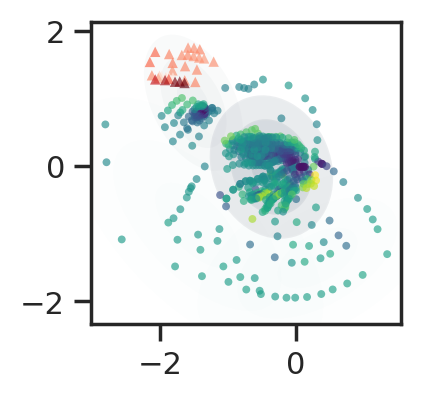

In [ ]:
gm = GaussianMixture(n_components=4, random_state=0, init_params='kmeans').fit(latents) #plot a n_components v.s. Average negative log likelihood
print('Average negative log likelihood:', -1*gm.score(latents))
plot_gmm(gm, latents)

Using elbow method to find out the best # of components, 
the lower the negative log likehood the better the model is, but too many cluster is trivial. just imagine you fit each individual data points with a Gaussian, in this case, you would have a very good model. but the such fitting is not very useful.


In this case, the best number of cluster is either 4 or 5.


In [ ]:
scores=[] #using elbow method to find out the best # of components
for i in range(1,12):
  gm = GaussianMixture(n_components=i, random_state=0, init_params='kmeans').fit(latents)
  print('Average negative log likelihood:', -1*gm.score(latents))
  scores.append(-1*gm.score(latents))

Average negative log likelihood: 1.6934940458870427
Average negative log likelihood: 1.5939515381329854
Average negative log likelihood: 1.3446285344006002
Average negative log likelihood: 1.3329691491445406
Average negative log likelihood: 1.1957491673672727
Average negative log likelihood: 1.1577345788629838
Average negative log likelihood: 1.1085116154613388
Average negative log likelihood: 1.106149515195862
Average negative log likelihood: 1.0059797843308775
Average negative log likelihood: 1.012995374227744
Average negative log likelihood: 0.9596908609051571


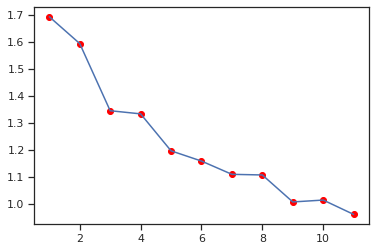

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(range(1,12), scores,color='red')
plt.plot(range(1,12),scores)
plt.show()

#INVAR Classifier

A simple neural network classifier that predicts INVAR based on composition. 

In [ ]:
class Classifier(nn.Module): #a very simple classifer with large dropout. intuition here: as simple as possible, given that we only have 2d input
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2,8),
            nn.Dropout(0.5),
            nn.Linear(8,1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc(x)

**Classifier training**

Again you can play around with params just to see how it affects the model accuracy (training and tesing)

In [ ]:
same_seeds(1)

params['cls_bs'] = 16
params['cls_lr'] = 1e-4
params['cls_epoch'] = 100
params['num_fold'] = 5


params['label_y'] = np.where(raw_y<5, 1, 0)
params['latents'] = latents

cls = Classifier().to(device)
opt = Adam(cls.parameters(), lr=params['cls_lr'], weight_decay=0.)


def training_Cls(model, optimizer, params):
    label_y = params['label_y']
    latents = params['latents']
    cls_epoch = params['cls_epoch']

    kf = KFold(n_splits=params['num_fold'])
    train_acc = []
    test_acc = []

    k=1
    for train, test in kf.split(latents):
        x_train, x_test, y_train, y_test = latents[train], latents[test], label_y[train], label_y[test]
        cls_dataset = AttributeDataset(x_train, y_train)
        cls_dataloader = DataLoader(cls_dataset, batch_size=params['cls_bs'], shuffle=True)
        cls_testDataset = AttributeDataset(x_test, y_test)
        cls_testDataloader = DataLoader(cls_testDataset, batch_size=cls_testDataset.__len__(), shuffle=False)


        for epoch in range(cls_epoch):
            t = time.time()
            total_loss = []
            total_acc = []
            cls.train()
            
            for i, data in enumerate(cls_dataloader):
                x = data[0].to(device)
                y = data[1].to(device)
                y_pred = cls(x)
                loss = F.binary_cross_entropy(y_pred, y)
                total_acc.append(torch.sum(torch.where(y_pred>=0.5,1,0) == y).detach().cpu().numpy())
                total_loss.append(loss.item())

                opt.zero_grad()
                loss.backward()
                opt.step()
            
            #eval
            cls.eval()
            for test in cls_testDataloader:
                x = test[0].to(device)
                y = test[1].to(device)
                y_pred = cls(x)
                accuracy = torch.sum(torch.where(y_pred>=0.5,1,0) == y) / y_pred.size(0)
                test_loss = F.binary_cross_entropy(y_pred, y)

            #print(f'[{epoch+1:03}/{cls_epoch}] loss:{sum(total_loss)/len(total_loss):.3f} test_loss:{test_loss.item():.3f} acc:{sum(total_acc)/cls_dataset.__len__():.3f} test_acc:{accuracy:.3f} time:{time.time()-t:.3f}')
        
        print('[{}/{}] train_acc: {:.04f} || test_acc: {:.04f}'.format(k, params['num_fold'], sum(total_acc)/cls_dataset.__len__(), accuracy.item()))
        train_acc.append(sum(total_acc)/cls_dataset.__len__())
        test_acc.append(accuracy.item())
        k+=1
    print('train_acc: {:.04f} || test_acc: {:.04f}'.format(sum(train_acc)/len(train_acc), sum(test_acc)/len(test_acc)))
    return train_acc, test_acc

train_acc, test_acc = training_Cls(cls, opt, params)

[1/5] train_acc: 0.8183 || test_acc: 0.8929
[2/5] train_acc: 0.8797 || test_acc: 0.7122
[3/5] train_acc: 0.8205 || test_acc: 0.9065
[4/5] train_acc: 0.8474 || test_acc: 0.8058
[5/5] train_acc: 0.8276 || test_acc: 0.9137
train_acc: 0.8387 || test_acc: 0.8462


#Markov Chain Monte Carlo for composition sampling

In [ ]:
def MCMC(gm, classifier, n_samples, sigma=0.1): #MCMC
    sample_z = []

    z = gm.sample(1)[0]
    for i in range(n_samples):
        uniform_rand = np.random.uniform(size=1)
        z_next = np.random.multivariate_normal(z.squeeze(),sigma*np.eye(2)).reshape(1,-1)

        z_combined = np.concatenate((z, z_next),axis=0)
        scores = cls(torch.Tensor(z_combined).to(device)).detach().cpu().numpy().squeeze() 
        z_score, z_next_score = np.log(scores[0]), np.log(scores[1]) #z score needes to be converted to log, coz gm score is log.
        z_prob, z_next_prob = (gm.score(z)+z_score), (gm.score(z_next)+z_next_score) # two log addition, output: log probability
        accepence = min(0, (z_next_prob - z_prob))

        if i == 0:
            sample_z.append(z.squeeze())

        if np.log(uniform_rand) < accepence:
            sample_z.append(z_next.squeeze())
            z = z_next
        else:
            pass

    return np.stack(sample_z)

Sample 5000 times with sigma=0.5

In [ ]:
sample_z = MCMC(gm=gm, classifier=cls, n_samples=5000, sigma=0.5)
WAE_comps = model._decode(torch.Tensor(sample_z).to(device)).detach().cpu().numpy()  # new_comps save as csv and goes to TERM
print('Sample size:', sample_z.shape)

Sample size: (1129, 2)


In [ ]:
WAE_comps=pd.DataFrame(WAE_comps)
WAE_comps.columns=column_name
WAE_comps.to_csv('comps_WAE.csv',index=False)
WAE_comps.head()

Fe        Ni        Co        Cr         V        Cu
0  0.621771  0.278061  0.066139  0.033976  0.000051  0.000002
1  0.290811  0.193655  0.426399  0.000012  0.089111  0.000012
2  0.356562  0.032219  0.479116  0.132074  0.000014  0.000015
3  0.232804  0.026366  0.633758  0.107050  0.000015  0.000007
4  0.431049  0.083583  0.353330  0.132014  0.000015  0.000009

Plotting the sampled composition along with known datas

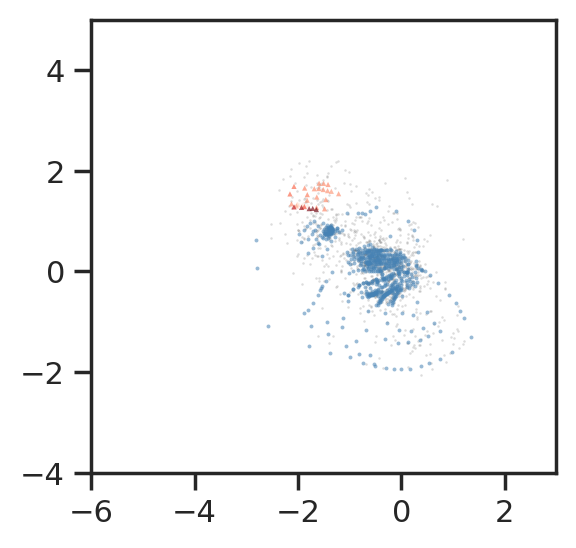

In [ ]:
sns.set_style('ticks')

t = time.localtime()
model_dir = os.path.join(root, '{}/{}_{}.pth'.format(params['model_name'], params['model_name'], params['num_epoch']))
model = WAE(raw_x.shape[1]).to(device)
model.load_state_dict(torch.load(model_dir))
model.eval()

dataset = FeatureDataset(raw_x[:], raw_y[:])
latents = get_latents(model,dataset)

low_cu = raw_x[:,5] < 0.05
low_cu_latent = latents[low_cu]
low_cu_color = raw_y[:][low_cu]

high_cu = raw_x[:,5] >= 0.05
high_cu_latent = latents[high_cu]
high_cu_color = raw_y[:][high_cu]

fig, axs = plt.subplots(figsize = (3, 3),dpi=200)

axs.set_xlim(-6,3)
axs.set_ylim(-4,5)

scatter1 = axs.scatter(low_cu_latent[:,0], low_cu_latent[:,1], c='steelblue', alpha=.55, s=2, linewidths=0, cmap='viridis')
scatter2 = axs.scatter(high_cu_latent[:,0], high_cu_latent[:,1], c=high_cu_color, alpha=.65, s=3.5, linewidths=0, cmap='Reds', marker='^')

scatter4 = axs.scatter(sample_z[:,0], sample_z[:,1], c='k', alpha=.15, s=0.8, linewidths=0, zorder=-1)

plt.show()

#Two-stage ensemble regression model (TERM)

**Ultility functions**
*   MAPELoss - Mean Absolute Percentile Error (MAPE)
*   normalizing_data - Normalizing the data



In [ ]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import random

class MAPELoss(nn.Module):
     def __init__(self):
        super(MAPELoss, self).__init__() 
        
     def forward (self, output, target):
         loss = torch.mean(torch.abs((target - output) / target))
         # loss = (-1)*loss
         return loss
     
def minmaxscaler(data):
    min = np.amin(data)
    max = np.amax(data)    
    return (data - min)/(max-min)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
class FeatureDataset(Dataset):
    '''
    Args: x is a 2D numpy array [x_size, x_features]
    '''
    def __init__(self, x):
        self.x = x
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.x[idx])

    def getBatch(self, idxs = []):
        if idxs == None:
            return idxs
        else:
            x_features = []
            for i in idxs:
                x_features.append(self.__getitem__(i))
            return torch.FloatTensor(x_features)
        
def normalizing_data(data, seed=42):  
  df_all = data.drop(columns=['alloy'])
  #create a min max processing object
  composition = df_all [['Fe','Ni','Co','Cr','V','Cu']]
  min_max_scaler = preprocessing.MinMaxScaler()
  normalized_atomic_properties = min_max_scaler.fit_transform(df_all[['VEC','AR1','AR2','PE','Density',
                                              'TC','MP','FI','SI','TI','M']])
  x = pd.concat([composition,pd.DataFrame(normalized_atomic_properties)],axis=1)
  x=x.iloc[:697]
  y = df_all[['TEC']][:697]
  # bins     = [18,35,48,109,202,234,525,687,695]
  bins     = [18,35,48,109,202,234,525,687]
  y_binned = np.digitize(y.index, bins, right=True) #stratified 7-fold: each folder contains a specific type of alloys (7 types in total, each takes 85% and 15% as training and testing)

  x = torch.FloatTensor(x.values) #numpy to tensor
  y = torch.FloatTensor(y.values) #numpy to tensor

  if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda() 
  
  train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.15, random_state=seed, stratify=y_binned)
  return train_features, test_features, train_labels, test_labels

**Data loading**

In [ ]:
import datetime
import torch.utils.data as Data
import pandas as pd
import torch
import torch.nn.functional as F    
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from bayes_opt import BayesianOptimization
import time
import os
from sklearn import preprocessing


t = time.localtime()
    
table = pd.DataFrame(columns=['target','batch_size','lr','module__n_hidden','module__w'])

plt.close('all')
starttime = datetime.datetime.now()
data = pd.read_csv('data_base.csv')


train_features, test_features, train_labels, test_labels = normalizing_data(data, seed=42)

In [ ]:
  print(torch.cuda.is_available())

False


**Neural network architecture**

In [ ]:

class Net(nn.Module):  
    def __init__(self, n_feature=17, n_hidden=218, n_output=1, w = 6):
        super(Net, self).__init__()    
        # self.BN=torch.nn.BatchNorm1d(n_hidden)
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden) 
        nn.init.kaiming_normal_(self.hidden1.weight)
        
        self.hiddens = nn.ModuleList ([nn.Linear(n_hidden, n_hidden) for i in range(w)])                            
        for m in self.hiddens:
            nn.init.kaiming_normal_(m.weight)   
        
        self.predict = torch.nn.Linear(n_hidden, n_output)  
        nn.init.kaiming_normal_(self.predict.weight)

    def forward(self, x):  
        x = self.hidden1(x)
        # x = self.BN(x)
        # x = self.Dropout (x)
        x = F.relu(x)   
        
        for m in self.hiddens:
            x = m(x)
            # x = self.BN(x)
            x = F.relu(x) 
                      
        x = self.predict(x)
        # x = self.BN_3(x)
        # x = self.Dropout (x)
          # 输出值
        return x

def train(net, num_epochs, batch_size, train_features, test_features, train_labels, test_labels,
          train_loader,
          optimizer):
    print ("\n=== train begin ===")
    print(net)
    train_ls, test_ls = [], []
    loss = MAPELoss() # MAPE means Mean Absolute percentile error 
    for epoch in range(num_epochs):
        for x, y in train_loader:
            ls = loss(net(x).view(-1, 1), y.view(-1, 1))
            optimizer.zero_grad()
            ls.backward()
            optimizer.step()
        if epoch % 100 == 0:
            train_ls.append(loss(net(train_features).view(-1, 1), train_labels.view(-1, 1)).item())
            test_ls.append(loss(net(test_features).view(-1, 1), test_labels.view(-1, 1)).item())
            print ("epoch %d: train loss %f, test loss %f" % (epoch, train_ls[-1], test_ls[-1]))
        
    print ("=== train end ===")
    
def test(model, test_loader):
    model.eval()
    test_loss = 0
    n = 0
    loss = MAPELoss() 
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss(output.view(-1, 1), target.view(-1, 1)).item()  # sum up batch loss
            n += 1

    test_loss /= n
    
    print('Test set: Average loss: {:.4f}'.format(
        test_loss))
    
    return test_loss   

    


def train_model(batch_size,lr, module__n_hidden,module__w):
    module__n_hidden = int(module__n_hidden) # number of neurons per layer
    module__w = int(module__w) # number of hidden layers
    batch_size = int(batch_size)
    train_dataset = Data.TensorDataset(train_features, train_labels)
    test_dataset = Data.TensorDataset(test_features, test_labels)
    train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = Data.DataLoader(test_dataset, batch_size, shuffle=True) 
    net = Net(n_feature=17, n_hidden=module__n_hidden, n_output=1, w = module__w)
    if torch.cuda.is_available():
      net = net.cuda()
    n_epochs = 20 
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
    train(net, n_epochs, batch_size,train_features, test_features, 
          train_labels, test_labels,train_loader, optimizer)
    train_loss= test(net,train_loader)
    test_loss = test(net, test_loader)

    
    r = -np.abs(train_loss-test_loss)
    
    return -test_loss
          

    

**Bayesian hyperparameter optimization**



In [ ]:
bounds = {'lr': (0.0005,0.001), 'batch_size': (32,64), 'module__n_hidden': (16,526),
          'module__w': (2,10)}
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=1)
print(optimizer.max)
table = pd.DataFrame(columns=['target','batch_size','lr','module__n_hidden','module__w'])
for res in optimizer.res:
    table=table.append(pd.DataFrame({'target':[res['target']],'batch_size':[res['params']['batch_size']],
                                     'lr':[res['params']['lr']], 'module__n_hidden':[res['params']['module__n_hidden']],
                                     'module__w':[res['params']['module__w']]}),ignore_index=True)
table=table.append(pd.DataFrame({'target':[optimizer.max['target']],'batch_size':[optimizer.max['params']['batch_size']],
                                    'lr':[optimizer.max['params']['lr']], 'module__n_hidden':[optimizer.max['params']['module__n_hidden']],
                                    'module__w':[optimizer.max['params']['module__w']]}),ignore_index=True)
model_name = 'Invar_inference_NN'
file_name = '{}.xlsx'.format(model_name)
endtime = datetime.datetime.now()
Rtime = endtime - starttime
print(Rtime)
table.to_excel(file_name)

|   iter    |  target   | batch_... |    lr     | module... | module__w |
-------------------------------------------------------------------------

=== train begin ===
Net(
  (hidden1): Linear(in_features=17, out_features=16, bias=True)
  (hiddens): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
  )
  (predict): Linear(in_features=16, out_features=1, bias=True)
)
epoch 0: train loss 0.964084, test loss 0.962973
=== train end ===
Test set: Average loss: 0.6662
Test set: Average loss: 0.6617
|  1        | -0.6617   |  45.34    |  0.000860 |  16.06    |  4.419    |

=== train begin ===
Net(
  (hidden1): Linear(in_features=17, out_features=110, bias=True)
  (hiddens): ModuleList(
    (0): Linear(in_features=110, out_features=110, bias=True)
    (1): Linear(in_features=110, out_features=1

In [ ]:
table.head()

target  batch_size        lr  module__n_hidden  module__w
0 -0.661725   45.344704  0.000860         16.058331   4.418661
1 -0.478543   36.696189  0.000546        110.992708   4.764486
2 -0.321303   44.696559  0.000769        229.789202   7.481756
3 -0.435235   38.542472  0.000939         29.967673   7.363740
4 -0.419314   45.353754  0.000779         87.597339   3.584812

**Load top 2 NN model with 2 different seeds**

Due to the data size problem, we even need to train the model with different seed in order to obtain a robust ensemble.

4
4

=== train begin ===
Net(
  (hidden1): Linear(in_features=17, out_features=110, bias=True)
  (hiddens): ModuleList(
    (0): Linear(in_features=110, out_features=110, bias=True)
    (1): Linear(in_features=110, out_features=110, bias=True)
    (2): Linear(in_features=110, out_features=110, bias=True)
    (3): Linear(in_features=110, out_features=110, bias=True)
  )
  (predict): Linear(in_features=110, out_features=1, bias=True)
)
epoch 0: train loss 0.927659, test loss 0.914057
plot curves
4
4

=== train begin ===
Net(
  (hidden1): Linear(in_features=17, out_features=110, bias=True)
  (hiddens): ModuleList(
    (0): Linear(in_features=110, out_features=110, bias=True)
    (1): Linear(in_features=110, out_features=110, bias=True)
    (2): Linear(in_features=110, out_features=110, bias=True)
    (3): Linear(in_features=110, out_features=110, bias=True)
  )
  (predict): Linear(in_features=110, out_features=1, bias=True)
)
epoch 0: train loss 0.924145, test loss 0.888590
plot curves
7


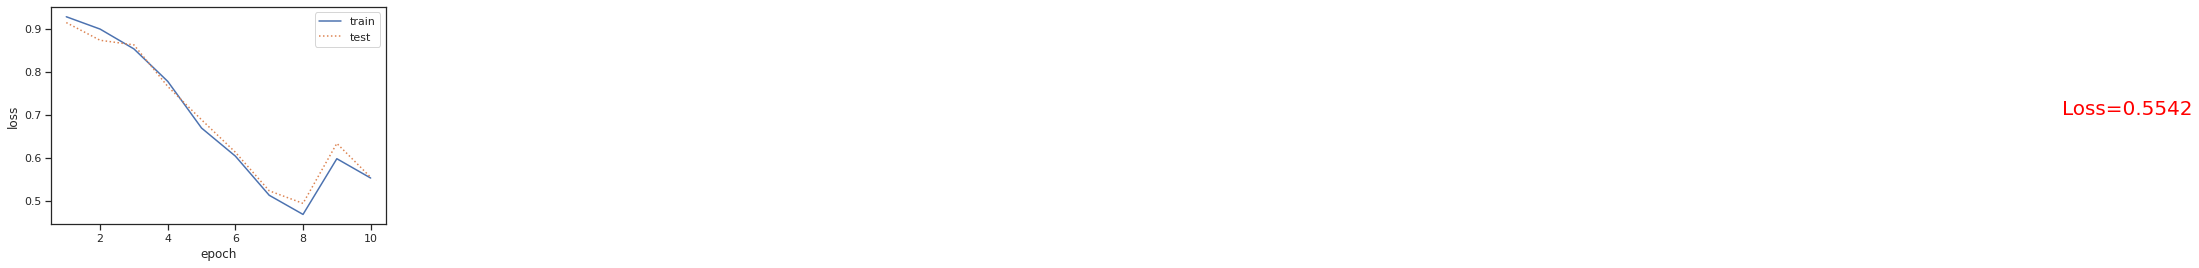

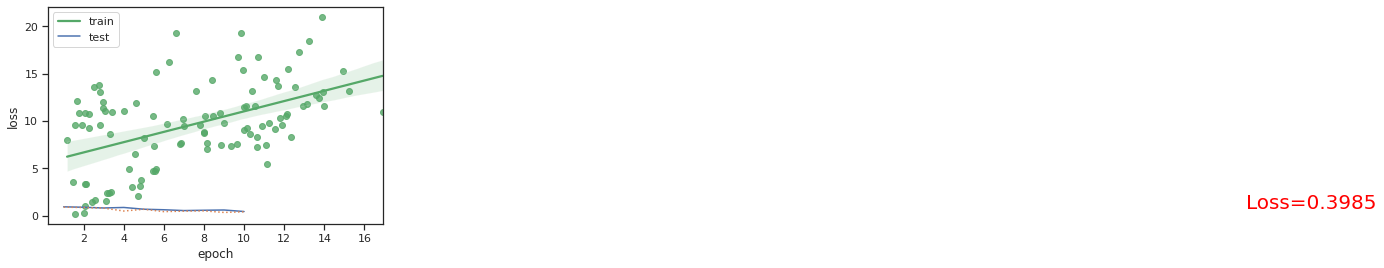

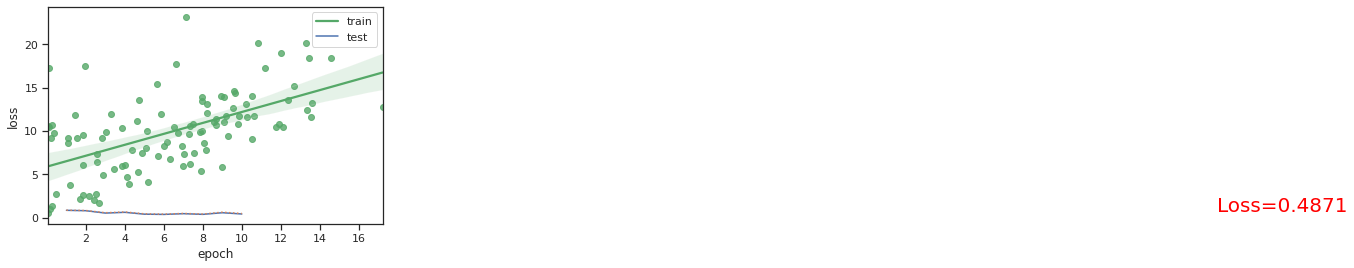

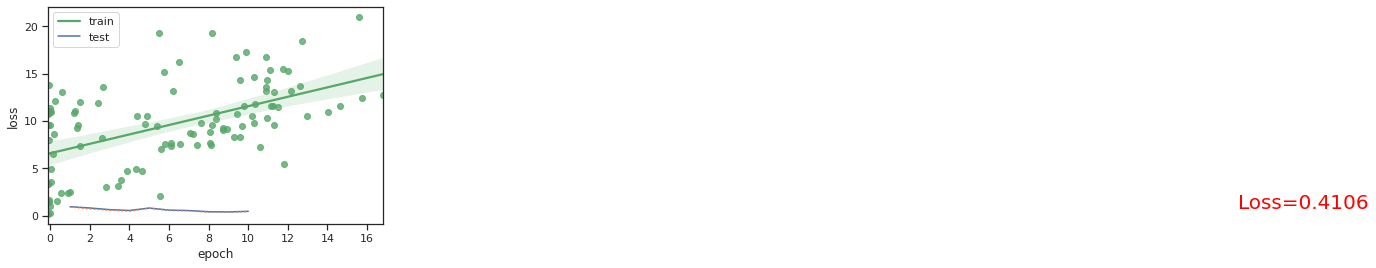

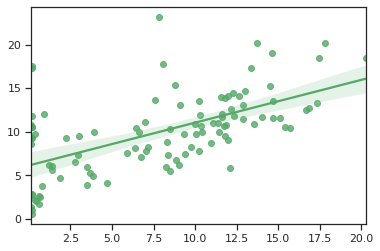

In [ ]:
import datetime
import torch.utils.data as Data
import pandas as pd
import torch
import torch.nn.functional as F   
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import time
import os
import pickle 
import seaborn as sns
t = time.localtime() 
plt.close('all')
target = pd.read_excel('Invar_inference_NN.xlsx')
starttime = datetime.datetime.now()
for i in range(1,3): # This is to choose best 10 points 
    for j in range(40,42): # 10 different seeds
        train_features, test_features, train_labels, test_labels = normalizing_data(data, seed=j)
        lr = target.at[i,'lr'] # the same
        module__n_hidden = target.at[i,'module__n_hidden']
        module__w = target.at[i,'module__w']
        batch_size = target.at[i,'batch_size']
        
        module__n_hidden = int(module__n_hidden)
        module__w = int(module__w)
        batch_size = int(batch_size)
        print (module__w)
        
        batch_size = target.at[i,'batch_size'] # choose 'batch_size' paramter at ith row
        lr = target.at[i,'lr'] # the same
        module__n_hidden = target.at[i,'module__n_hidden']
        module__w = target.at[i,'module__w']
        
        module__n_hidden = int(module__n_hidden)
        module__w = int(module__w)
        batch_size = int(batch_size)
        print (module__w)
        train_dataset = Data.TensorDataset(train_features, train_labels)
        test_dataset = Data.TensorDataset(test_features, test_labels)
        train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
        test_loader = Data.DataLoader(test_dataset, batch_size, shuffle=True) 
            

        class Net(nn.Module):  
            def __init__(self, n_feature=17, n_hidden=module__n_hidden, n_output=1, w = module__w):
                super(Net, self).__init__()   
                # self.BN=torch.nn.BatchNorm1d(n_hidden)
                self.hidden1 = torch.nn.Linear(n_feature, n_hidden) 
                nn.init.kaiming_normal_(self.hidden1.weight)
                
                self.hiddens = nn.ModuleList ([nn.Linear(n_hidden, n_hidden) for i in range(w)])                            
                for m in self.hiddens:
                    nn.init.kaiming_normal_(m.weight)   
                
                self.predict = torch.nn.Linear(n_hidden, n_output) 
                nn.init.kaiming_normal_(self.predict.weight)
        
            def forward(self, x): 
                x = self.hidden1(x)
                # x = self.BN(x)
                # x = self.Dropout (x)
                x = F.relu(x)   
                
                for m in self.hiddens:
                    x = m(x)
                    # x = self.BN(x)
                    x = F.relu(x) 
                              
                x = self.predict(x)
                # x = self.BN_3(x)
                # x = self.Dropout (x)
                return x
   
        def plotCurve(x_vals, y_vals, 
                        x_label, y_label, 
                        x2_vals=None, y2_vals=None, 
                        legend=None,
                        figsize=(3.5, 2.5)):
            # set figsize
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.plot(x_vals, y_vals)
            if x2_vals and y2_vals:
                plt.plot(x2_vals, y2_vals, linestyle=':')
            
            if legend:
                plt.legend(legend)
        #training 
        print ("\n=== train begin ===")
        
        net = Net()
        print(net)
        if torch.cuda.is_available():
            net = net.cuda()    
        train_ls, test_ls = [], []
        loss = MAPELoss() 
        n_epochs = 10
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
        for epoch in range(n_epochs):
            for x, y in train_loader:
                ls = loss(net(x).view(-1, 1), y.view(-1, 1))
                optimizer.zero_grad()
                ls.backward()
                optimizer.step()
            train_ls.append(loss(net(train_features).view(-1, 1), train_labels.view(-1, 1)).item())
            test_ls.append(loss(net(test_features).view(-1, 1), test_labels.view(-1, 1)).item())
            if epoch % 100 == 0:
                print ("epoch %d: train loss %f, test loss %f" % (epoch, train_ls[-1], test_ls[-1]))
        print ("plot curves")
        plotCurve(range(1, n_epochs + 1), train_ls,"epoch", "loss",range(1, n_epochs + 1), test_ls,["train", "test"])
        plt.text(60, 0.7, 'Loss=%.4f' % test_ls[-1], fontdict={'size': 20, 'color':  'red'})
        fig_name_1 = '{}-{}_1.png'.format(i,j)
        plt.savefig(fig_name_1, format='png', dpi=300)            
                   
        #plotting
        net.eval()
        predict=net(test_features)
        predict=predict.cpu()
        predict=predict.data.numpy()  
        plt.figure()
        sns.regplot(x=predict, y=test_labels.cpu().data.numpy(), color='g') 
        fig_name_2 = 'NN_rank_{}-seed_{}.png'.format(i,j)
        plt.savefig(fig_name_2, format='png', dpi=300)
         
        #save the models
        net_name = 'NN_rank_{}-seed_{}.pt'.format(i,j)
        torch.save(net.state_dict(), net_name)
        
endtime = datetime.datetime.now()
Rtime = endtime - starttime
print(Rtime)

**Gradient Boosting Decision Tree Ensemble (GBDT)**

In [ ]:
import os
import time
from bayes_opt import BayesianOptimization
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import numpy as np
#import seaborn as sns
#from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime
import pandas as pd

t = time.localtime()
model_name = 'Invar_inference_GBDT'
file_name = '{}.xlsx'.format(model_name)
data = pd.read_csv('data_base.csv')
train_features, test_features, train_labels, test_labels = normalizing_data(data,seed=42)
train_features, test_features = train_features.cpu().data.numpy(),test_features.cpu().data.numpy()
train_labels, test_labels = train_labels.cpu().data.numpy(), test_labels.cpu().data.numpy()
train_labels, test_labels = train_labels.reshape(-1), test_labels.reshape(-1) 
def train_model(num_leaves,
                min_child_samples,
            learning_rate,
            n_estimators, 
            max_bin,
            colsample_bytree, 
            subsample, 
            max_depth, 
            reg_alpha,
            reg_lambda,
            min_split_gain,
            min_child_weight
            ):
    params = {
        "num_leaves": int(round(num_leaves)),
        'min_child_samples':int(round(min_child_samples)),
        'learning_rate': learning_rate,
        'n_estimators': int(round(n_estimators)),
        'max_bin': int(round(max_bin)),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'max_depth': int(round(max_depth)),
        'reg_alpha':  max(reg_alpha, 0),
        'reg_lambda': max(reg_lambda, 0),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'verbose': -1
                  }
    model = LGBMRegressor(**params)
    model.fit(train_features, train_labels)
    y_pred = model.predict(test_features)
    error = -np.mean(np.abs((test_labels - y_pred) / test_labels))       # print(error)     
    return error
bounds = {'num_leaves': (5, 60),#50
          'min_child_samples':(1, 50),
          'learning_rate': (0.001, 1),
          'n_estimators': (5, 200),#100
            'max_bin': (5, 100),#10
          'colsample_bytree': (0.5, 1),
          'subsample': (0.1, 2),
          'max_depth': (1, 60),#10
          'reg_alpha': (0.01, 1), #5
          'reg_lambda': (0.01, 1),#5
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (0.0001, 30)}
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
)
optimizer.maximize(init_points = 10, n_iter=1)
table = pd.DataFrame(columns=['target', 'colsample_bytree', 'learning_rate', 'max_bin',
                      'max_depth','min_child_samples','min_child_weight','min_split_gain',
                      'n_estimators','num_leaves','reg_alpha','reg_lambda','subsample'])
for res in optimizer.res:
    table=table.append(pd.DataFrame({'target':[res['target']],'colsample_bytree':[res['params']['colsample_bytree']],
                                     'colsample_bytree':[res['params']['colsample_bytree']],
                                     'learning_rate':[res['params']['learning_rate']],
                                     'max_bin':[res['params']['max_bin']],
                                     'max_depth':[res['params']['max_depth']],
                                     'min_child_samples':[res['params']['min_child_samples']],
                                     'min_child_weight':[res['params']['min_child_weight']],
                                     'min_split_gain':[res['params']['min_split_gain']],
                                     'n_estimators':[res['params']['n_estimators']],
                                     'num_leaves':[res['params']['num_leaves']],
                                     'reg_alpha':[res['params']['reg_alpha']],
                                     'reg_lambda':[res['params']['reg_lambda']],
                                     'subsample':[res['params']['subsample']]}),
                                     ignore_index=True)
table=table.append(pd.DataFrame({'target':[optimizer.max['target']],'colsample_bytree':[optimizer.max['params']['colsample_bytree']],
                                 'colsample_bytree':[optimizer.max['params']['colsample_bytree']],
                                 'learning_rate':[optimizer.max['params']['learning_rate']],
                                 'max_bin':[optimizer.max['params']['max_bin']],
                                 'max_depth':[optimizer.max['params']['max_depth']],
                                 'min_child_samples':[optimizer.max['params']['min_child_samples']],
                                 'min_child_weight':[optimizer.max['params']['min_child_weight']],
                                 'min_split_gain':[optimizer.max['params']['min_split_gain']],
                                 'n_estimators':[optimizer.max['params']['n_estimators']],
                                 'num_leaves':[optimizer.max['params']['num_leaves']],
                                 'reg_alpha':[optimizer.max['params']['reg_alpha']],
                                 'reg_lambda':[optimizer.max['params']['reg_lambda']],
                                 'subsample':[optimizer.max['params']['subsample']]}),
                                 ignore_index=True)
table.to_excel(file_name)
endtime = datetime.datetime.now()
print ('running time {}'.format(endtime - starttime))

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.3299   |  0.7085   |  0.7206   |  5.011    |  18.84    |  8.191    |  2.77     |  0.01944  |  72.38    |  26.82    |  0.5434   |  0.425    |  1.402    |
|  2        | -0.5844   |  0.6022   |  0.8782   |  7.602    |  40.56    |  21.45    |  16.76    |  0.0149   |  43.63    |  49.04    |  0.9686   |  0.3203   |  1.415    |
|  3        | -0.2229   |  0.9382   |  0.8947   |  13.08    |  3.304    |  9.322    |  26.34    |  0.01074  |  87.12    |  57.68    |  0.5378   |  0.695    |  0.6995   |
|  4        | -0.3351   |  0.8433   |  0.8348   |  6.737    |  45.26    |  49.45    |  22.44    |  0.02876  |  158.9    |  10.68    |  0.4534   |  0.9

**Introducing the atomic properties**

All were found in the standard text book.
e.g., valence electron concentration(VEC)

In [ ]:
def atomic_properties(new_comps):
  df_test = new_comps.copy()
  df_test['VEC'] = 8*df_test['Fe'] + 10*df_test['Ni'] + 9*df_test['Co'] + 6*df_test['Cr'] + 5*df_test['V'] + 11*df_test['Cu']
  df_test['AR1'] = 140*df_test['Fe'] + 135*df_test['Ni'] + 135*df_test['Co'] + 140*df_test['Cr'] + 135*df_test['V'] + 135*df_test['Cu']
  df_test['AR2'] = 124*df_test['Fe'] + 125*df_test['Ni'] + 125*df_test['Co'] + 125*df_test['Cr'] + 132*df_test['V'] + 128*df_test['Cu']
  df_test['PE'] = 1.83*df_test['Fe'] + 1.91*df_test['Ni'] + 1.88*df_test['Co'] + 1.66*df_test['Cr'] + 1.63*df_test['V'] + 1.9*df_test['Cu']
  df_test['Density'] = 7874*df_test['Fe'] + 8908*df_test['Ni'] + 8900*df_test['Co'] + 7140*df_test['Cr'] + 6110*df_test['V'] + 8920*df_test['Cu']
  df_test['TC'] = 80*df_test['Fe'] + 91*df_test['Ni'] + 100*df_test['Co'] + 94*df_test['Cr'] + 30.7*df_test['V'] + 400*df_test['Cu']
  df_test['MP'] = 1181*df_test['Fe'] + 1728*df_test['Ni'] + 1768*df_test['Co'] + 2180*df_test['Cr'] + 2183*df_test['V'] + 1357.77*df_test['Cu']
  df_test['FI'] = 762.47*df_test['Fe'] + 737.14*df_test['Ni'] + 760.4*df_test['Co'] + 652.87*df_test['Cr'] + 650.91*df_test['V'] + 745.78*df_test['Cu']
  df_test['SI'] = 1562.98*df_test['Fe'] + 1753.03*df_test['Ni'] + 1648.39*df_test['Co'] + 1590.69*df_test['Cr'] + 1412*df_test['V'] + 1957.92*df_test['Cu']
  df_test['TI'] = 2957.4*df_test['Fe'] + 3395*df_test['Ni'] + 3232.3*df_test['Co'] + 2987.1*df_test['Cr'] + 2828.09*df_test['V'] + 3554.6*df_test['Cu']
  df_test['M'] = 2.22*df_test['Fe'] + 0.6*df_test['Ni'] + 1.72*df_test['Co'] + -0.6*df_test['Cr'] + 0.0*df_test['V'] + 0.0*df_test['Cu']
  return df_test

In [ ]:
WAE_comps=pd.read_csv('comps_WAE.csv')

In [ ]:
WAE_comps.head()

Fe        Ni        Co        Cr         V        Cu
0  0.621771  0.278061  0.066139  0.033976  0.000051  0.000002
1  0.290811  0.193655  0.426399  0.000012  0.089111  0.000012
2  0.356562  0.032219  0.479116  0.132074  0.000014  0.000015
3  0.232804  0.026366  0.633758  0.107050  0.000015  0.000007
4  0.431049  0.083583  0.353330  0.132014  0.000015  0.000009

In [ ]:
WAE_comps=atomic_properties(WAE_comps)

In [ ]:
WAE_comps.head()

Fe        Ni        Co  ...           SI           TI         M
0  0.621771  0.278061  0.066139  ...  1622.408826  3098.264551  1.640541
1  0.290811  0.193655  0.426399  ...  1622.753743  3147.844701  1.495193
2  0.356562  0.032219  0.479116  ...  1613.687947  3107.137533  1.555734
3  0.232804  0.026366  0.633758  ...  1625.087152  3146.339692  1.558479
4  0.431049  0.083583  0.353330  ...  1612.702447  3095.030896  1.535598

[5 rows x 17 columns]

We want the atomic properties to be normalized (so that it can be understood by neural networks)

In [ ]:
composition= WAE_comps[['Fe','Ni','Co','Cr','V','Cu']]
min_max_scaler = preprocessing.MinMaxScaler()
normalized_atomic_properties = min_max_scaler.fit_transform(WAE_comps[['VEC','AR1','AR2','PE','Density',
                                              'TC','MP','FI','SI','TI','M']])
WAE_x = pd.concat([composition,pd.DataFrame(normalized_atomic_properties)],axis=1)

In [ ]:
WAE_x.head()

Fe        Ni        Co  ...         8         9        10
0  0.621771  0.278061  0.066139  ...  0.304340  0.311627  0.647061
1  0.290811  0.193655  0.426399  ...  0.306213  0.428373  0.554423
2  0.356562  0.032219  0.479116  ...  0.256987  0.332520  0.593009
3  0.232804  0.026366  0.633758  ...  0.318883  0.424829  0.594758
4  0.431049  0.083583  0.353330  ...  0.251636  0.304013  0.580175

[5 rows x 17 columns]

**The final ensemble model**

the final ensembles combine 4 GBDT and 4 NN to predict TEC of the WAE-generated compositions.

In [ ]:
def Tree(n,j, WAE_x):
    target = pd.read_excel('Invar_inference_GBDT.xlsx')
    colsample_bytree = target.at[n,'colsample_bytree']
    learning_rate = target.at[n,'learning_rate']
    max_bin = target.at[n,'max_bin']
    max_depth = target.at[n,'max_depth']
    max_bin = target.at[n,'max_bin']
    min_child_samples = target.at[n,'min_child_samples']
    min_child_weight = target.at[n,'min_child_weight']
    min_split_gain= target.at[n,'min_split_gain']
    n_estimators = target.at[n,'n_estimators']
    num_leaves = target.at[n,'num_leaves']
    reg_alpha = target.at[n,'reg_alpha']
    reg_lambda = target.at[n,'reg_lambda']
    subsample = target.at[n,'subsample']
    params = {
        "num_leaves": int(round(num_leaves)),
        'min_child_samples':int(round(min_child_samples)),
        'learning_rate': learning_rate,
        'n_estimators': int(round(n_estimators)),
        'max_bin': int(round(max_bin)),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'max_depth': int(round(max_depth)),
        'reg_lambda':  max(reg_lambda, 0),
        'reg_alpha': max(reg_alpha, 0),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'objective': 'regression',
        'verbose': -1
                 }
    data=pd.read_csv('data_base.csv')             
    train_features, test_features, train_labels, test_labels = normalizing_data(data,seed=j)
    train_features, test_features = train_features.cpu().data.numpy(),test_features.cpu().data.numpy()
    train_labels, test_labels = train_labels.cpu().data.numpy(), test_labels.cpu().data.numpy()
    train_labels, test_labels = train_labels.reshape(-1), test_labels.reshape(-1)   
    model = LGBMRegressor(**params)
    model.fit(train_features, train_labels)
    preds = model.predict(WAE_x)
    return preds

class Net(nn.Module):  
        def __init__(self, n_feature, n_hidden, n_output, w):
            super(Net, self).__init__()   
            # self.BN=torch.nn.BatchNorm1d(n_hidden)
            self.hidden1 = torch.nn.Linear(n_feature, n_hidden) 
            nn.init.kaiming_normal_(self.hidden1.weight)
            
            self.hiddens = nn.ModuleList ([nn.Linear(n_hidden, n_hidden) for i in range(w)])                            
            for m in self.hiddens:
                nn.init.kaiming_normal_(m.weight)   
            
            self.predict = torch.nn.Linear(n_hidden, n_output) 
            nn.init.kaiming_normal_(self.predict.weight)
    
        def forward(self, x): 
            x = self.hidden1(x)
            # x = self.BN(x)
            # x = self.Dropout (x)
            x = F.relu(x)   
            
            for m in self.hiddens:
                x = m(x)
                # x = self.BN(x)
                x = F.relu(x) 
                          
            x = self.predict(x)
            # x = self.BN_3(x)
            # x = self.Dropout (x)
            return x
        
def NN(n,seed, WAE_x):
    target = pd.read_excel('Invar_inference_NN.xlsx')
    batch_size = target.at[n,'batch_size']
    lr = target.at[n,'lr']
    module__n_hidden = target.at[n,'module__n_hidden']
    module__w = target.at[n,'module__w']
    module__n_hidden = int(module__n_hidden)
    module__w = int(module__w)
    batch_size = int(batch_size)
    net = Net(n_feature=17, n_hidden=module__n_hidden, n_output=1, w = module__w)
    print(net)
    #load模型
    net.load_state_dict(torch.load('NN_rank_{}-seed_{}.pt'.format(n,seed)))
    net.eval()
    Comp_NN = torch.FloatTensor(WAE_x.values)
    preds = net(Comp_NN)
    preds=preds.data.numpy()
    return preds

#   
r=0
Comp_total = pd.DataFrame()
for i in range(1,3):
    for j in range(40,42):
        #Tree
        print ('prediction_Tree_{}'.format(r))
        prediction = Tree(i,j,WAE_x)
        Comp_total['pred_Z_Tree_{}'.format(r)] = prediction
        #NN
        print ('prediction_NN_{}'.format(r))
        prediction = NN(i,j,WAE_x)
        Comp_total['pred_Z_NN_{}'.format(r)] = prediction    
        r += 1

prediction_Tree_0
prediction_NN_0
Net(
  (hidden1): Linear(in_features=17, out_features=110, bias=True)
  (hiddens): ModuleList(
    (0): Linear(in_features=110, out_features=110, bias=True)
    (1): Linear(in_features=110, out_features=110, bias=True)
    (2): Linear(in_features=110, out_features=110, bias=True)
    (3): Linear(in_features=110, out_features=110, bias=True)
  )
  (predict): Linear(in_features=110, out_features=1, bias=True)
)
prediction_Tree_1
prediction_NN_1
Net(
  (hidden1): Linear(in_features=17, out_features=110, bias=True)
  (hiddens): ModuleList(
    (0): Linear(in_features=110, out_features=110, bias=True)
    (1): Linear(in_features=110, out_features=110, bias=True)
    (2): Linear(in_features=110, out_features=110, bias=True)
    (3): Linear(in_features=110, out_features=110, bias=True)
  )
  (predict): Linear(in_features=110, out_features=1, bias=True)
)
prediction_Tree_2
prediction_NN_2
Net(
  (hidden1): Linear(in_features=17, out_features=229, bias=True)
  

#Rank-based exploration-exploitation strategy

In this case, we emphasize on exploitation - more weights on mean prediction
(0.8) and less on std prediction(0.2). then we use the top - 6 compositions for the next stage computation (DFT-involved)

In [ ]:
prediciton_mean = Comp_total.mean(axis=1)
prediciton_std = Comp_total.std(axis=1)
WAE_x['prediction_mean'] = prediciton_mean
WAE_x['prediction_std'] = prediciton_std
WAE_x['rank_score'] =prediciton_std*0.2+prediciton_mean*0.8

In [ ]:
WAE = WAE_x[['Fe','Ni','Co','Cr','V','Cu','prediction_mean', 'prediction_std','rank_score']]

In [ ]:
WAE.sort_values(by=['rank_score'])

Fe        Ni        Co  ...  prediction_mean  prediction_std  rank_score
875   0.619835  0.377426  0.000539  ...        -0.226008        1.745752    0.168344
608   0.593359  0.337972  0.061585  ...        -0.007902        1.469721    0.287623
603   0.654393  0.341160  0.001058  ...         0.209429        1.688600    0.505263
935   0.584634  0.336610  0.072283  ...         0.290606        1.489233    0.530331
604   0.624872  0.329524  0.030967  ...         0.465375        1.003058    0.572911
...        ...       ...       ...  ...              ...             ...         ...
1083  0.558625  0.320308  0.021384  ...        16.318293        4.025232   13.859681
874   0.479208  0.318671  0.075633  ...        17.232318        2.473666   14.280588
309   0.522177  0.311523  0.047142  ...        17.223517        3.162425   14.411299
1061  0.493232  0.317133  0.059200  ...        17.639513        2.647319   14.641074
20    0.509453  0.318668  0.043539  ...        17.707118        2.899516   14.745597

[1129 rows x 9 columns]

Congrats! you have completed the tutorial!

For more information and complete version of this notebook, please stay tuned to the paper: 

'Ziyuan Rao et cl, A universally applicable active-learning framework for functional high-entropy alloy discovery, in preparation, 2021'